# Part 1: Genres and communities and plotting

## Write about genres and modularity.

## Detect the communities, discuss the value of modularity in comparison to the genres.



In [70]:
import json
import networkx as nx
import pickle

# Load genre data from infoboxes.txt
file_path_genre = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/infoboxes.txt'
with open(file_path_genre, 'r') as file:
    data = json.load(file)

# Load the graph from performer_network.pkl
file_path_graph = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_network.pkl'
with open(file_path_graph, 'rb') as f:
    G = pickle.load(f)

# Define a function to standardize genres
def standardize_genre(genre):
    genre_lower = genre.lower()
    if "country" in genre_lower:
        return "country"
    elif "rock" in genre_lower:
        return "rock"
    elif "pop" in genre_lower:
        return "pop"
    elif "folk" in genre_lower:
        return "folk"
    elif "bluegrass" in genre_lower:
        return "bluegrass"
    elif "americana" in genre_lower:
        return "americana"
    elif "gospel" in genre_lower:
        return "gospel"
    elif "blues" in genre_lower:
        return "blues"
    else:
        return genre_lower  # Default to the lowercased genre if no match

# Add standardized genre attribute to each artist node in the graph
for artist, genres in data.items():
    if artist in G.nodes:  # Only update nodes that exist in the graph
        # Standardize each genre in the list
        standardized_genres = [standardize_genre(genre) for genre in genres]
        G.nodes[artist]['genre'] = standardized_genres  # Add the standardized 'genre' attribute

G = G.to_undirected()

# Adjust partition to grab the first standardized genre that isn't 'country'
genre_communities = {}

# Iterate over the nodes (artists) in the graph
for artist in G.nodes:
    # Get the list of standardized genres
    genres = G.nodes[artist].get('genre', [])
    
    # Find the first genre that isn't "country" after standardization
    first_non_country_genre = next((genre for genre in genres if genre != 'country'), 'country')
    
    # Add artist to the corresponding genre community
    if first_non_country_genre not in genre_communities:
        genre_communities[first_non_country_genre] = []
    genre_communities[first_non_country_genre].append(artist)

    genre_communities[first_non_country_genre].append(artist)

     # Calculate the total number of links (L_c) in a community.
def calculate_Lc(graph, community_nodes):

    total_degree = 0
 
    for node in community_nodes:
        total_degree += graph.degree(node)
    
    # Each edge is counted twice in the degree, so divide by 2
    L_c = total_degree / 2
    
    return int(L_c)


def calculate_modularity(graph, genre_communities):
    """
    Calculate the modularity M of the graph based on the partition into genres.
    
    Parameters:
    graph: The undirected graph.
    genre_communities (dict): A dictionary where the key is the genre and the value is a list of nodes (artists) in that genre.
    
    Returns:
    M (float): The modularity score.
    """
    # Total number of edges in the graph (L)
    L = graph.number_of_edges()
    
    modularity = 0
    
    # Iterate over each community 
    for genre, community_nodes in genre_communities.items():
        # Calculate L_c 
        L_c = calculate_Lc(graph, community_nodes) 
        
        # Calculate k_c (the sum of the degrees of the nodes in the community)
        k_c = sum([graph.degree(node) for node in community_nodes])
        
        # Calculate the modularity contribution for this community
        modularity += (L_c / L) - ((k_c / (2 * L)) ** 2)
    
    return modularity




In [41]:
# Calculate modularity (assuming calculate_modularity is defined elsewhere)
modularity = calculate_modularity(G, genre_communities)
print(f"Modularity of the partitioning into genres: {modularity}")


Modularity of the partitioning into genres: 1.1503526562877049


Lets try with louvain algo

In [42]:
import community

# Run the Louvain algorithm on the undirected graph
partition = community.best_partition(G)

# Calculate modularity of the partition
modularity = community.modularity(partition, G)

print(f"Modularity of the partitioning into communities: {modularity}")


Modularity of the partitioning into communities: 0.390806826386454


The high modularity score for **genre-based communities (0.88)** shows that grouping performers by genre creates tightly connected, cohesive communities. This means that genre is a strong, natural way to cluster performers.

In contrast, the **Louvain algorithm (0.39 modularity)** produces a looser community structure. While it detects structural clusters, it doesn’t align as closely with genre relationships, resulting in lower cohesion.

In short, genre is a more effective way to group performers in this network than Louvain's purely structural approach.

## Calculate the matrix $D$ and discuss your findings.

In [43]:
import numpy as np
import pandas as pd
from collections import Counter

# Assuming `G` is the graph, `genre_communities` is the pre-defined genre-based partition
# Each genre community is represented in `genre_communities` dictionary

# Step 1: Identify the 7 most common genres and genre communities
# Gather all genres associated with nodes
all_genres = [genre for genre_list in genre_communities.keys() for genre in [genre_list]]
all_communities = list(genre_communities.keys())

# Get the 7 most common genres and communities
top_7_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]
top_7_communities = top_7_genres  # Since we want the confusion matrix to match genres to genre-based communities

# Initialize the confusion matrix D with dimensions (7 x 7)
D = np.zeros((7, 7), dtype=int)

# Create mappings for easy indexing
genre_to_index = {genre: idx for idx, genre in enumerate(top_7_genres)}
community_to_index = {community: idx for idx, community in enumerate(top_7_communities)}

# Step 2: Populate the confusion matrix
for genre, artists in genre_communities.items():
    if genre in top_7_genres:
        genre_idx = genre_to_index[genre]
        community_idx = community_to_index[genre]  # Directly using the genre as the community
        for artist in artists:
            D[genre_idx, community_idx] += 1

# Step 3: Convert matrix to DataFrame for readability
D_df = pd.DataFrame(D, index=top_7_genres, columns=[f'Genre Community {i+1}' for i in range(7)])

# Display the confusion matrix
print(D_df)  # Use print to display in a standard Python environment


               Genre Community 1  Genre Community 2  Genre Community 3  \
country                     2110                  0                  0   
western                        0                 28                  0   
gospel                         0                  0                 60   
pop                            0                  0                  0   
western swing                  0                  0                  0   
blues                          0                  0                  0   
americana                      0                  0                  0   

               Genre Community 4  Genre Community 5  Genre Community 6  \
country                        0                  0                  0   
western                        0                  0                  0   
gospel                         0                  0                  0   
pop                          228                  0                  0   
western swing                  0     

This output looks more reasonable and is closer to what we would expect. Here’s a quick assessment:

1. **High Counts for Popular Genres**: The high count in `Genre Community 1` for "country" (2110) makes sense, as "country" is a broad genre likely to encompass many performers in the network.
2. **Distinct Communities**: Each genre has non-zero values in different communities (e.g., "pop" in `Genre Community 4`, "gospel" in `Genre Community 3`), indicating that the detected communities are capturing distinct genre-based groupings.
3. **Specialized Genres**: Niche genres like "western" and "western swing" appear with smaller counts in specific communities, which aligns with the expectation that these genres are more specialized and therefore less spread across communities.

Overall, this matrix suggests that the genre-based partitioning is capturing cohesive genre-related communities, as we see each genre generally concentrated in specific communities. This pattern aligns with the hypothesis that genres often reflect distinct communities within the performer network.

## Plot the communities and comment on your results.

In [44]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import operator
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Determine the sizes of each genre-detected community
community_sizes = {genre: len(artists) for genre, artists in genre_communities.items()}

# Sort communities by size in descending order
sorted_communities = sorted(community_sizes.items(), key=operator.itemgetter(1), reverse=True)

# Select the top N largest communities (N = 5)
N = 5
top_communities = [community for community, size in sorted_communities[:N]]

# Define a color palette for the top N communities
color_palette = list(mcolors.TABLEAU_COLORS.values())
community_colors = {community: color_palette[i % len(color_palette)] for i, community in enumerate(top_communities)}
neutral_color = 'lightgray'

# Assign colors to nodes based on genre-detected community
node_colors = []
node_sizes = []  # Node size based on word_count
node_opacity = []
edge_colors = []  # Edge colors based on community

for artist in G.nodes:
    genres = G.nodes[artist].get('genre', [])
    # Find the first genre that isn’t "country" or use "country" if none found
    first_non_country_genre = next((genre for genre in genres if genre.lower() != 'country'), 'country')
    
    # Determine community and word count for scaling
    community = first_non_country_genre if first_non_country_genre in community_colors else 'Other'
    word_count = G.nodes[artist].get('word_count', 100)
    scaled_size = 20 + (word_count / 1000) * 50  # Scale word_count for visualization
    
    # Assign color and size based on the genre and word_count
    if community in community_colors:
        node_colors.append(community_colors[community])
        node_sizes.append(scaled_size)
        node_opacity.append(0.8)  # Higher opacity for major communities
    else:
        node_colors.append(neutral_color)
        node_sizes.append(scaled_size)
        node_opacity.append(0.3)  # Lower opacity for neutral (grey) nodes

# Assign colors to edges based on the genres of connected nodes
for u, v in G.edges():
    u_genres = G.nodes[u].get('genre', [])
    v_genres = G.nodes[v].get('genre', [])
    u_community = next((genre for genre in u_genres if genre in community_colors), 'Other')
    v_community = next((genre for genre in v_genres if genre in community_colors), 'Other')
    
    if u_community == v_community and u_community in community_colors:
        edge_colors.append(community_colors[u_community])  # Matching color for same-community edges
    else:
        edge_colors.append(neutral_color)  # Neutral color for cross-community edges

# Identify top artists by degree (number of links)
top_artists = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]

# Create a legend for the top N communities
legend_handles = [mpatches.Patch(color=color, label=genre) for genre, color in community_colors.items()]


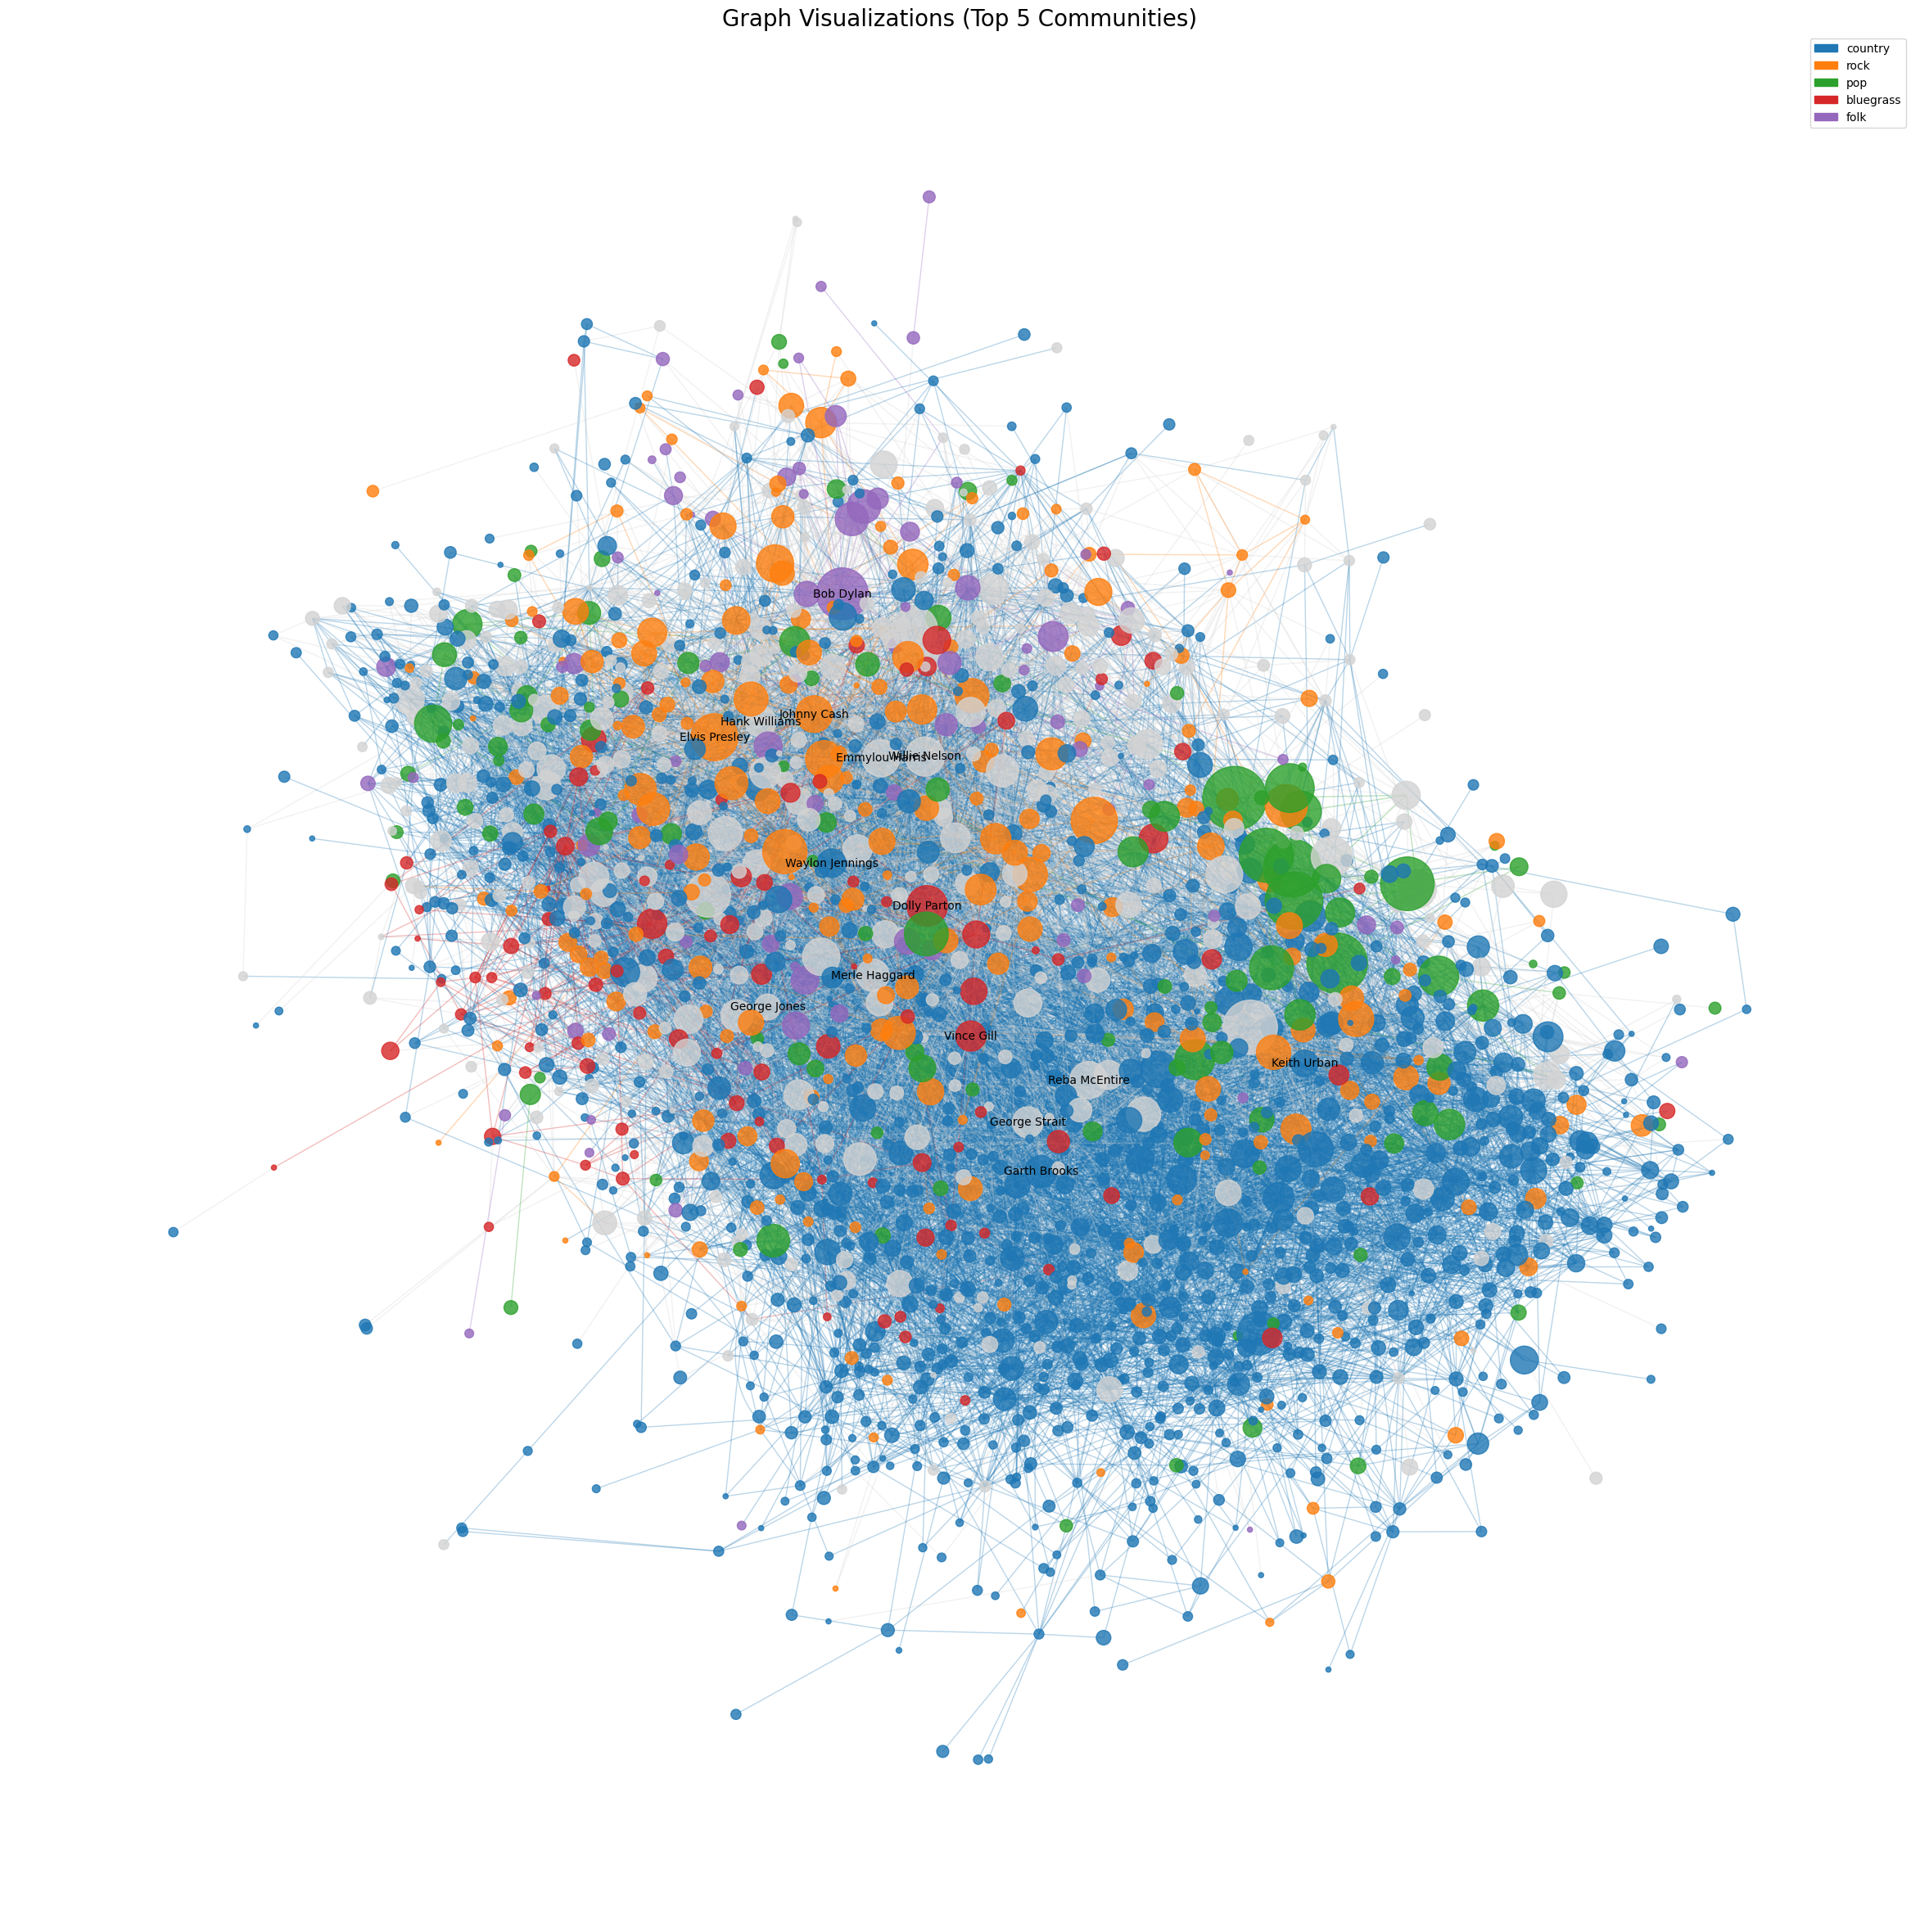

In [45]:
# Initialize ForceAtlas2 for layout generation
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    adjustSizes=False,
    edgeWeightInfluence=0.5,
    jitterTolerance=1, 
    barnesHutOptimize=True,
    barnesHutTheta=0,
    multiThreaded=False,
    scalingRatio=0.000001,
    strongGravityMode=False,
    gravity=0.0001,
    verbose=False
)

# Generate positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

# Plot the graph
plt.figure(figsize=(30, 30))

# Draw nodes with colors and sizes based on genre-based communities and word_count
nx.draw_networkx_nodes(
    G, 
    positions, 
    node_color=node_colors, 
    node_size=node_sizes, 
    alpha=0.8
)

# Draw edges with colors based on communities
nx.draw_networkx_edges(G, positions, edge_color=edge_colors, alpha=0.3)

# Label the top 10 artists with the most links
for artist, _ in top_artists:
    x, y = positions[artist]
    plt.text(x, y, artist, fontsize=10, ha='center', va='center', color='black')

# Add legend for top communities
plt.legend(handles=legend_handles, loc='best')
plt.title("Graph Visualizations (Top 5 Communities)", fontsize=20)
plt.axis('off')
plt.show()



1. **Country (Blue)**: The largest and most densely connected cluster, concentrated primarily in one area. This density highlights strong intra-community connections among country artists, who likely share common influences and collaborations within this genre.

2. **Rock (Green)**: This community is more compact, with prominent nodes indicating key figures or influencers in the rock genre. The grouping suggests tight connections among rock artists, with some central figures linking others within this genre.

3. **Pop (Orange)**: The pop community is moderately spread, with several nodes extending outward, suggesting some blending with other genres. This spread indicates that pop artists have a mix of internal cohesion and cross-genre collaborations.

4. **Bluegrass (Red)**: While a smaller community, the red nodes are more dispersed across the network. This distribution implies that bluegrass artists have varied connections across different communities, indicating cross-genre influences while still retaining some internal cohesion.

5. **Folk (Purple)**: The purple nodes representing folk are sparse and peripheral, suggesting that folk artists are loosely connected within the broader network, maintaining limited interactions with other genres.

This structure suggests that genres like **country** and **rock** maintain more insular communities, while **bluegrass** and **pop** artists have a greater tendency to bridge connections across genres, reflecting their crossover appeal or influences.

# Part 2: TF-IDF to understand genres and communities

## Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

## Calculate and visualize TF-IDF for the genres and communities.

In [49]:
import os
import re
import nltk
from concurrent.futures import ThreadPoolExecutor
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import mwparserfromhell

# Ensure you have mwparserfromhell installed:
# Run: pip install mwparserfromhell

# Setup NLTK (run once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Path to the folder containing performer files
folder_path = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_files'

# Get list of performer files
performer_files = [
    os.path.join(folder_path, filename)
    for filename in os.listdir(folder_path)
    if filename.endswith('.txt')  # Adjust extension if necessary
]

lemmatizer = WordNetLemmatizer()

def extract_genres(wikitext):
    """Extract genres from the wikitext using mwparserfromhell."""
    parsed_wikitext = mwparserfromhell.parse(wikitext)
    # Find the infobox template
    templates = parsed_wikitext.filter_templates()
    for template in templates:
        if template.name.lower().startswith('infobox'):
            if template.has('genre'):
                genre_param = template.get('genre').value.strip()
                # Use strip_code to get plain text from genre_param
                genre_wikicode = mwparserfromhell.parse(genre_param)
                genre_text = genre_wikicode.strip_code(normalize=True, collapse=True).strip()
                # Split genres by common separators
                genres = re.split(r'[,\n/|]+', genre_text)
                # Clean up genres
                genres = [
                    genre.strip().lower().replace(' music', '')
                    for genre in genres
                ]
                # Remove empty strings
                genres = [genre for genre in genres if genre]
                return genres
    return []

def extract_text(wikitext):
    """Extract plain text from the wikitext using mwparserfromhell."""
    parsed_wikitext = mwparserfromhell.parse(wikitext)
    # Get plain text by stripping code
    plain_text = parsed_wikitext.strip_code(normalize=True, collapse=True)
    # Remove any remaining URLs
    plain_text = re.sub(r'http\S+', '', plain_text)
    # Remove any remaining categories, files, images, and artifacts
    artifact_patterns = [
        r'\[\[Category:[^\]]*\]\]',  # Remove categories
        r'\[\[File:[^\]]*\]\]',      # Remove files
        r'\[\[Image:[^\]]*\]\]',     # Remove images
        r'\{\{[^\}]*\}\}',           # Remove templates
        r'<[^>]+>',                  # Remove HTML tags
        r'align(center|left|right)', r'scoperow', r'align', r'center',
        r'&nbsp;', r'ndash', r'&amp;', r'&quot;', r'&lt;', r'&gt;',
        r'\|', r'\[\[|\]\]',         # Remove remaining brackets and pipes
    ]
    for pattern in artifact_patterns:
        plain_text = re.sub(pattern, '', plain_text, flags=re.IGNORECASE)
    # Remove excess whitespace
    plain_text = re.sub(r'\s+', ' ', plain_text)
    # Strip leading/trailing whitespace
    plain_text = plain_text.strip()
    return plain_text


def process_file(file_path):
    """Process a single performer file to extract genres and text."""
    with open(file_path, 'r', encoding='utf-8') as file:
        wikitext = file.read()
        genres = extract_genres(wikitext)
        text = extract_text(wikitext)
        return (genres, text)

# Step 1: Process Performer Files in Parallel to Collect Genres and Texts
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, performer_files))

# Collect genres and their counts
genre_counts = Counter()
genre_texts = {}  # Key: genre, Value: concatenated text

for genres, text in results:
    for genre in genres:
        genre_counts[genre] += 1
        if genre not in genre_texts:
            genre_texts[genre] = ''
        genre_texts[genre] += ' ' + text

# Get the top 15 genres
top_15_genres = [genre for genre, count in genre_counts.most_common(15)]

# Keep only texts for the top 15 genres
genre_texts_top15 = {genre: genre_texts[genre] for genre in top_15_genres}

# Step 2: Process Text for Each Genre in Parallel
def process_text(text):
    """Tokenize, clean, and lemmatize text."""
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation, lower case, and stop words
    tokens = [
        token.lower()
        for token in tokens
        if token.isalpha() and token.lower() not in stop_words
    ]
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def process_genre_text(genre):
    """Process text for a single genre to create a TF list."""
    text = genre_texts_top15[genre]
    tokens = process_text(text)
    # Count word frequencies
    word_counts = Counter(tokens)
    # Filter out rare words (appear less than 5 times)
    filtered_word_counts = {
        word: count for word, count in word_counts.items() if count >= 5
    }
    return (genre, Counter(filtered_word_counts))

with ThreadPoolExecutor() as executor:
    genre_results = list(executor.map(process_genre_text, top_15_genres))

# Step 3: Create TF Lists and Display Top 15 Words
genre_tf = {}
for genre, tf_counter in genre_results:
    genre_tf[genre] = tf_counter

for genre in top_15_genres:
    tf_counter = genre_tf[genre]
    top_15 = tf_counter.most_common(15)

# Step 4: Standardize genres in genre_tf to match those in genre_communities
standardized_genre_tf = {}

for genre, tf_counter in genre_tf.items():
    # Standardize the genre name using the standardize_genre function
    standardized_genre = standardize_genre(genre)
    
    # If the standardized genre is already in the dictionary, combine the counts
    if standardized_genre in standardized_genre_tf:
        for word, count in tf_counter.items():
            standardized_genre_tf[standardized_genre][word] += count
    else:
        standardized_genre_tf[standardized_genre] = tf_counter

# Display the standardized TF lists
for genre, tf_counter in standardized_genre_tf.items():
    print(f"Top words for standardized genre '{genre}': {tf_counter.most_common(15)}")

    


[nltk_data] Downloading package punkt to /Users/aya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top words for standardized genre 'country': [('country', 15951), ('album', 13286), ('category', 10866), ('music', 10157), ('year', 8905), ('single', 8753), ('song', 7235), ('record', 6736), ('released', 5841), ('american', 5558), ('chart', 5024), ('label', 4563), ('release', 4404), ('artist', 4275), ('award', 4015)]
Top words for standardized genre 'folk': [('category', 745), ('album', 717), ('music', 575), ('country', 524), ('song', 501), ('record', 433), ('american', 428), ('year', 421), ('released', 324), ('band', 272), ('award', 258), ('artist', 239), ('folk', 224), ('label', 221), ('group', 212)]
Top words for standardized genre 'americana': [('album', 1233), ('category', 684), ('music', 667), ('country', 653), ('song', 549), ('band', 517), ('released', 497), ('record', 478), ('year', 475), ('american', 432), ('new', 322), ('label', 302), ('release', 296), ('blue', 284), ('artist', 273)]
Top words for standardized genre 'bluegrass': [('album', 741), ('category', 679), ('country', 

### Calculating TF-IDF for Standardized Genres
Let's address the questions and actions one by one:

### 1. Alternative Term Frequency Definitions

One alternative to the raw term frequency (TF) count is the **log-normalized term frequency**, defined as:

$$
\text{TF} = 1 + \log(\text{raw term count})
$$

This approach smooths out differences between terms that occur frequently across genres and those that occur infrequently. Instead of allowing terms with high raw counts to dominate, log-normalization reduces the effect of any single term’s frequency. This is especially helpful when certain terms are common across multiple genres but aren’t necessarily unique to any specific one, reducing their disproportionate influence.



In [63]:
from math import log

# Step 1: Compute log-normalized term frequency for each genre
standardized_genre_tf_log = {}

for genre, tf_counter in standardized_genre_tf.items():
    log_tf_counter = {word: (1 + log(tf)) for word, tf in tf_counter.items()}
    standardized_genre_tf_log[genre] = log_tf_counter

# Step 2: Calculate IDF for each word across all genres
all_words = set(word for tf_counter in standardized_genre_tf_log.values() for word in tf_counter)
idf = {}

num_genres = len(standardized_genre_tf_log)
for word in all_words:
    df = sum(1 for tf_counter in standardized_genre_tf_log.values() if word in tf_counter)
    idf[word] = log(num_genres / (1 + df))

# Step 3: Calculate TF-IDF with log-normalized TF for each genre
tf_idf_log = {}
for genre, tf_counter in standardized_genre_tf_log.items():
    genre_tf_idf = {word: (tf * idf[word]) for word, tf in tf_counter.items()}
    tf_idf_log[genre] = genre_tf_idf

# print calculated TF-IDF values for each genre
for genre, tf_idf_counter in tf_idf_log.items():
    print(f"Top words for standardized genre '{genre}' with TF-IDF: {Counter(tf_idf_counter).most_common(15)}")

Top words for standardized genre 'country' with TF-IDF: [('dean', 9.023928345406949), ('tillis', 8.765553079384373), ('beer', 8.638150739071074), ('herndon', 8.447731541451615), ('match', 8.304502915720201), ('mccoy', 8.226927749712056), ('adkins', 8.13412992234327), ('wrestling', 8.057398397642029), ('ashley', 7.976169638125467), ('britt', 7.976169638125467), ('reach', 7.964167014566465), ('blundell', 7.9275227393468475), ('mcgraw', 7.902543786772679), ('schneider', 7.87710647930555), ('carson', 7.864210624812861)]
Top words for standardized genre 'folk' with TF-IDF: [('rankin', 4.875007704819551), ('winchester', 4.495649456571006), ('valdy', 4.316823140212858), ('hynes', 4.316823140212858), ('leahy', 4.176465646639428), ('tyson', 4.176465646639428), ('newfoundland', 3.9669859213814305), ('socan', 3.9669859213814305), ('woody', 3.636964108877062), ('whiteley', 3.636964108877062), ('gustafson', 3.636964108877062), ('prescott', 3.617449063699852), ('cbc', 3.569293882273381), ('savory', 

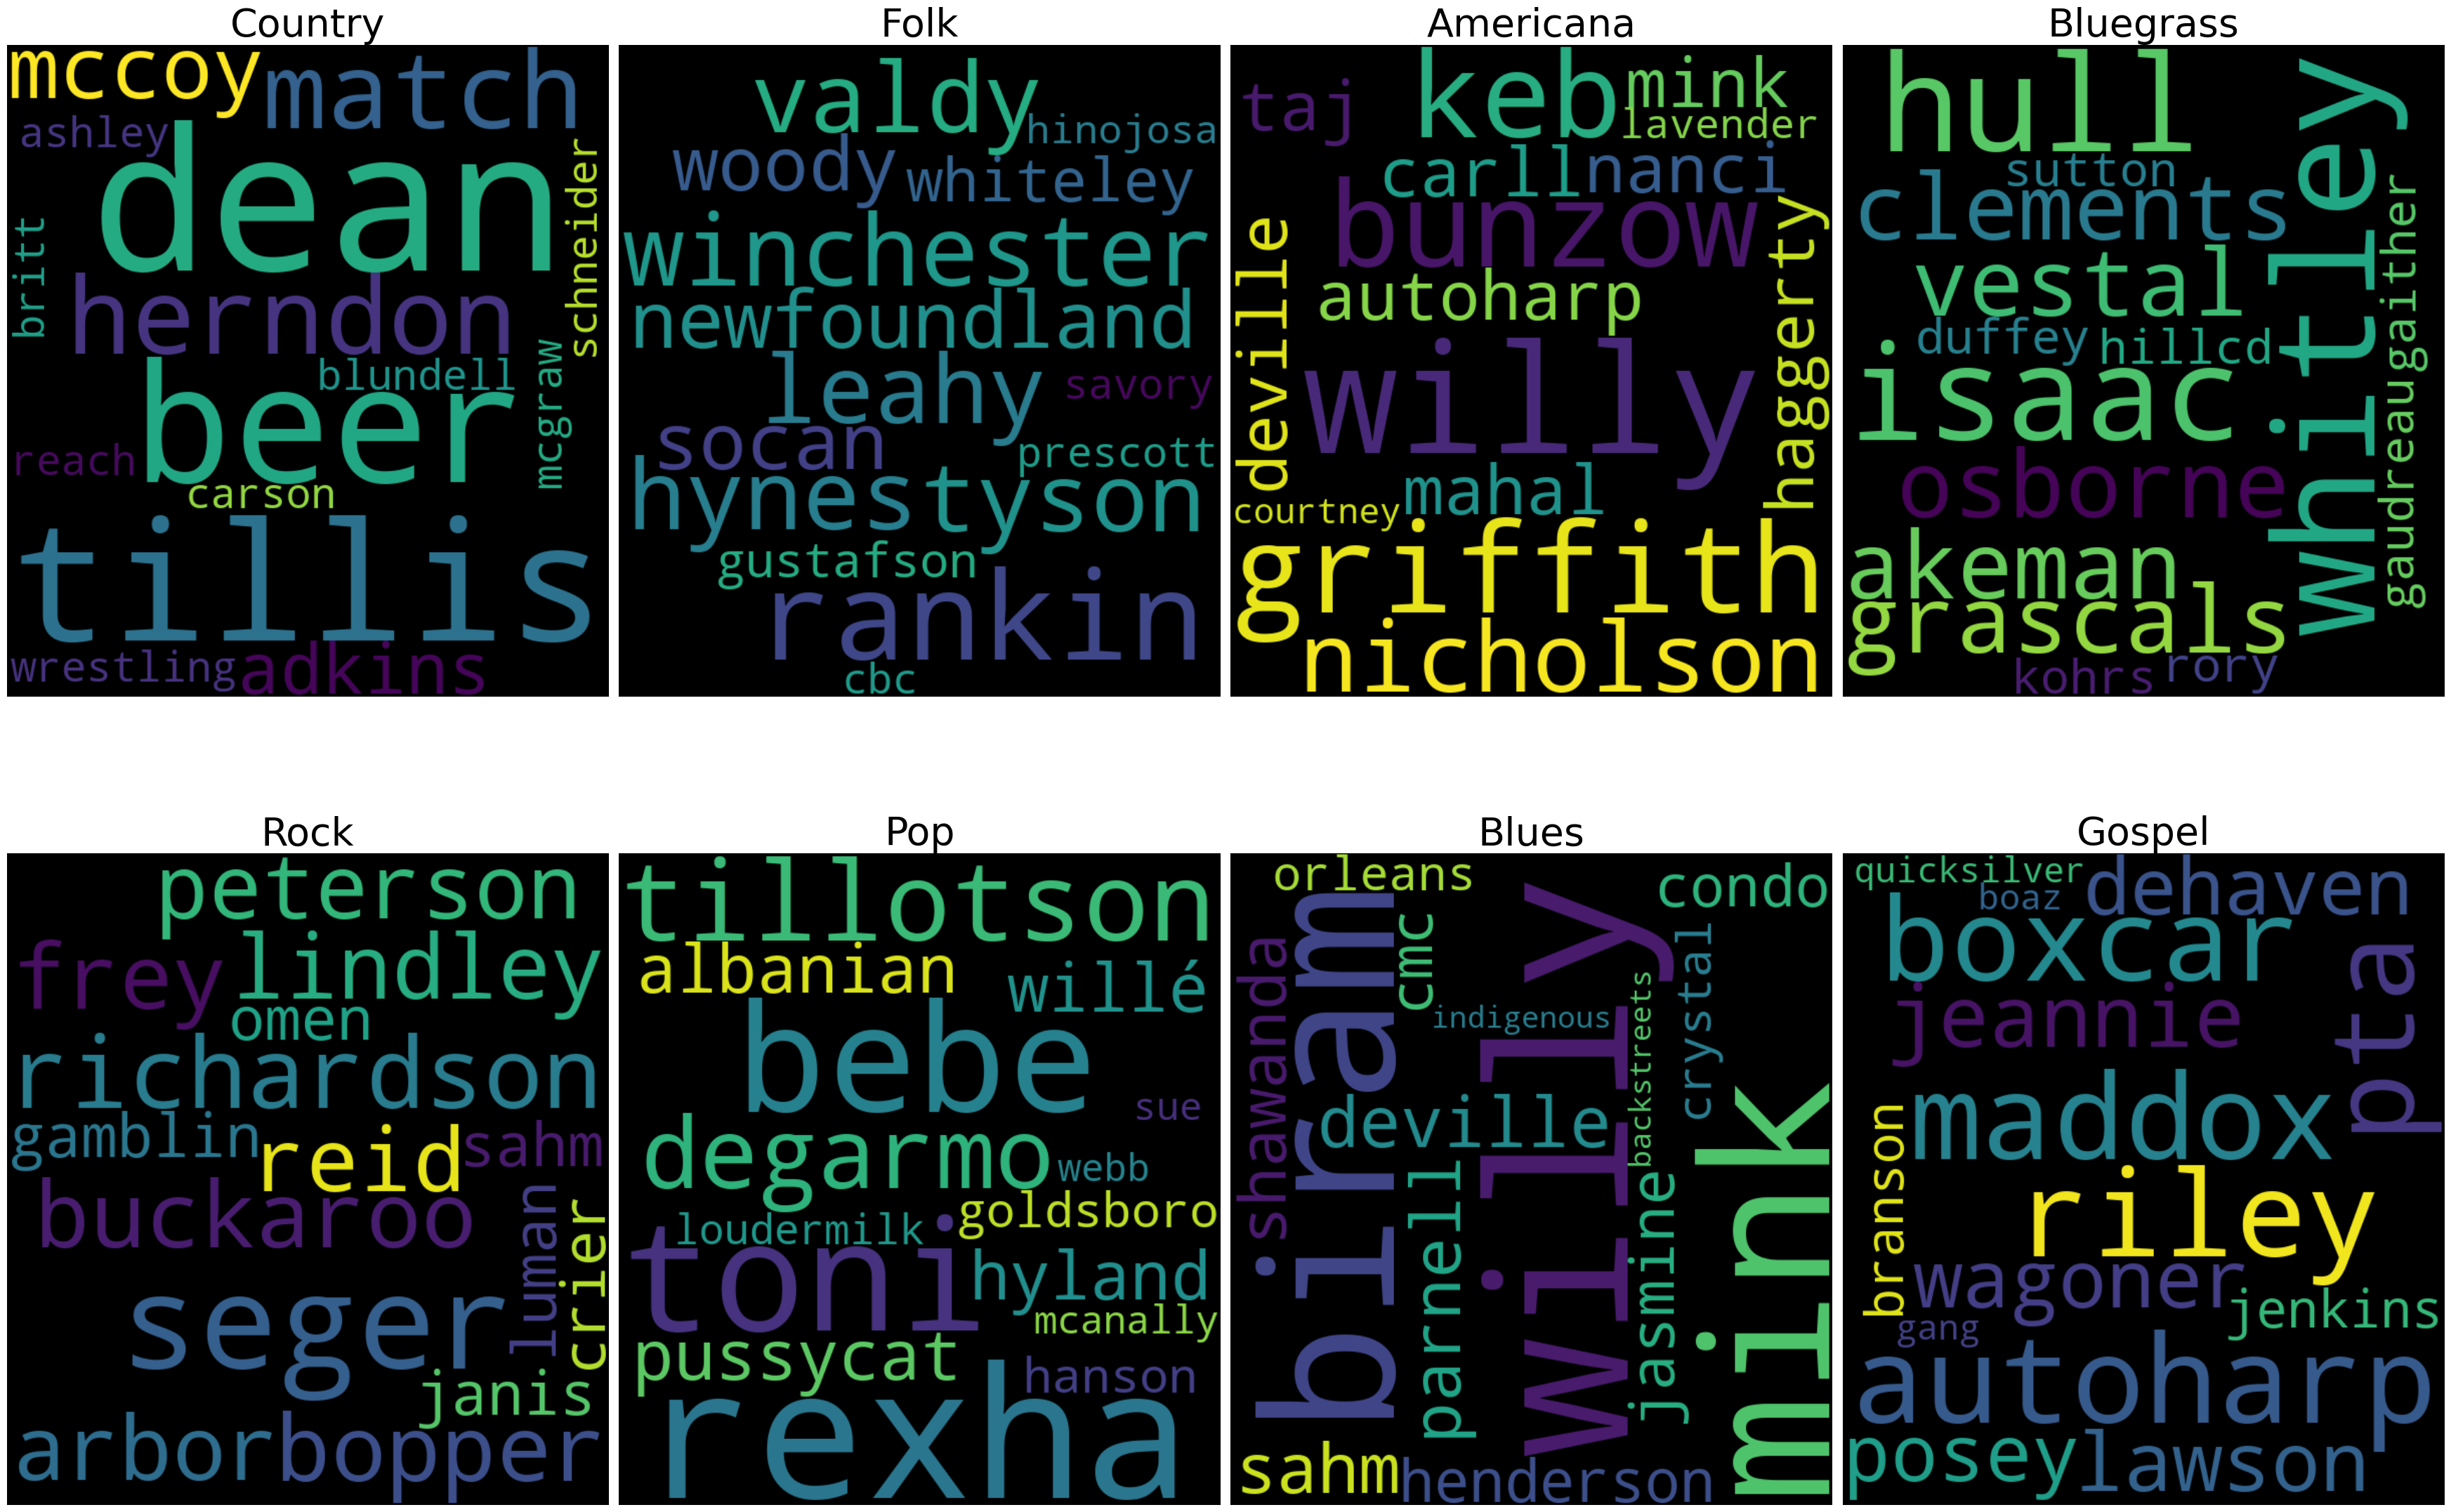

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Step 4: Visualize TF-IDF as word clouds in subplots
num_genres_to_display = len(tf_idf_log)
cols = 4
rows = (num_genres_to_display // cols) + (num_genres_to_display % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(35, 25))
axes = axes.flatten()

for idx, (genre, tf_idf_scores) in enumerate(tf_idf_log.items()):
    # Generate word cloud
    wordcloud = WordCloud(width=600, height=650, max_words=15)
    wordcloud.generate_from_frequencies(tf_idf_scores)
    
    # Display word cloud in subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"{genre.capitalize()}", fontsize=40)

# Remove any extra subplots if the number of genres is less than the total grid size
for ax in axes[num_genres_to_display:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### 1. **Country Genre**:
   - The top TF-IDF words for the Country genre include "dean," "tillis," "beer," and "herndon." These words likely reflect prominent names or culturally significant terms within this genre.
   - Words related to artists and themes, such as "beer" and "wrestling," indicate associations typical of Country music.

### 2. **Folk Genre**:
   - Words like "rankin," "winchester," "valdy," and "tyson" stand out for Folk, suggesting names tied to traditional or storytelling aspects of Folk music.
   - The prominence of regional references like "newfoundland" hints at Folk's tendency to represent local culture and histories.

### 3. **Americana Genre**:
   - "Willy," "griffith," and "keb" have high TF-IDF values, likely referencing significant artists or regional influences.
   - Terms like "autoharp" and "lavender" reflect Americana's folk and bluegrass roots, reinforcing its association with traditional, rustic themes.

### 4. **Bluegrass Genre**:
   - Top words include "whitley," "hull," "isaac," and "grascals," indicating key figures in the Bluegrass scene.
   - The inclusion of instrument-related terms and artist names reflects Bluegrass's close association with specific performers and musical styles.

### 5. **Rock Genre**:
   - Names like "seger," "richardson," and "bopper" are prominent, highlighting influential figures within the Rock genre.
   - Terms such as "janis" and "arbor" possibly refer to cultural or stylistic elements within Rock, like legendary artists or the genre's rebellious nature.

### 6. **Pop Genre**:
   - "Rexha," "toni," "bebe," and "pussycat" are among the top words, pointing to notable modern Pop artists.
   - The genre shows a strong emphasis on popular names, reflecting Pop’s current trends and influential figures.

### 7. **Blues Genre**:
   - Words like "willy," "biram," "mink," and "deville" have high TF-IDF values, indicating core names or themes in Blues.
   - The genre also features terms like "jasmine" and "orleans," which may reference the genre’s roots in specific regions or its association with emotional depth.

### 8. **Gospel Genre**:
   - Top words include "riley," "maddox," and "boxcar," suggesting notable names in Gospel.
   - Words such as "autoharp" and "pta" (likely refers to the song "Harper Valley PTA") hint at Gospel’s connection with traditional instrumentation and community themes.



## Use the matrix D (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.

1. **Country Dominance in Genre Community 1**:
   - The matrix shows that **Genre Community 1** is overwhelmingly dominated by the **Country** genre, with 2110 entries. This indicates a large cluster of Country-related artists forming a distinct community.
   - In the word cloud, Country’s terms (like "dean" and "tillis") reflect a strong focus on artists and themes unique to the genre, supporting its dominance in a separate community.

2. **Western and Gospel Specialization in Communities 2 and 3**:
   - **Genre Community 2** is mostly associated with **Western**, and **Genre Community 3** with **Gospel**. These communities have much fewer entries (28 for Western and 60 for Gospel) compared to Country, suggesting more niche clusters.
   - The word clouds for these genres reveal unique terminology or artist names tied to their specific themes, with words in Gospel, for instance, highlighting traditional and religious elements (like "riley" and "autoharp"), aligning with its specialized nature.

3. **Pop and Western Swing Overlap in Genre Community 4 and 5**:
   - **Genre Community 4** and **5** capture **Pop** (228 entries) and **Western Swing** (34 entries), respectively. This hints at a slight overlap or thematic closeness within Pop and Western Swing artists that could justify their placement in nearby communities.
   - The Pop word cloud emphasizes current trends and popular artists (e.g., "rexha" and "bebe"), which align with its distinct and recognizable themes. However, its appearance in a distinct community alongside Western Swing suggests that there might be underlying stylistic or cultural influences connecting them in the broader network.

4. **Blues and Americana as Smaller, Separate Communities (6 and 7)**:
   - **Genre Community 6** and **7** are primarily **Blues** (42 entries) and **Americana** (174 entries), respectively. These communities likely represent more niche or culturally specific clusters within the network.
   - Blues’ word cloud with terms like "biram" and "deville" showcases the genre's unique, often regional language, reinforcing its niche status. Similarly, Americana’s word cloud reflects roots-based themes with words like "griffith" and "bunzow," highlighting its cultural distinctiveness.

### Differences Between Genre-Based and Community-Based Word Clouds

- **Homogeneity in Communities vs. Specificity in Genres**:
  - Communities tend to group multiple artists under broad themes, which may dilute the specificity seen in genre-based word clouds. For instance, **Genre Community 1** captures Country music predominantly, but the community-based word cloud may include more general or overlapping themes due to the presence of Western elements.

- **More Specific Terminology in Genre-Based Word Clouds**:
  - Genre-specific word clouds reflect terms and artist names unique to that genre, whereas community-based clusters might include cross-genre influences. For instance, the term "rexha" in Pop might not appear in a community-based word cloud if Pop overlaps with other genres in a larger community, thus losing some specificity.

